In [373]:
%matplotlib inline

# Importing the necessary libraries and modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import util
import os
import scipy.stats as st

In [521]:
def format_k(y, _):
    if y > 1000 or y < -1000:
        return "{}k".format(int(y/1000))
    else:
        return int(y)

def format_time(seconds, _):
    """Formats a timedelta duration to [N days] %M:%S format"""
    secs_in_a_min = 60

    minutes, seconds = divmod(seconds, secs_in_a_min)

    time_fmt = "{:d}:{:02d}".format(minutes, seconds)
    return time_fmt

colors = {
  "Omni-Paxos": "dodgerblue",
  "Omni-Paxos replace follower": "dodgerblue",
  "Omni-Paxos replace leader": "midnightblue",
  "Omni-Paxos 1 min": "dodgerblue",
  "Omni-Paxos 2 min": "blue",
  "Omni-Paxos 4 min": "midnightblue",
  "Omni-Paxos 50ms": "dodgerblue",
  "Omni-Paxos 500ms": "lightskyblue",
  "Omni-Paxos 5000ms": "royalblue",
  "Omni-Paxos 10000ms": "royalblue",
  "Omni-Paxos, n=3": "dodgerblue",
  "Omni-Paxos, n=5": "midnightblue",

  "Raft": "orange",
  "Raft replace follower": "orange",
  "Raft replace leader": "crimson",
  "Raft, n=3": "orange",
  "Raft, n=5": "crimson",
  "Raft 1 min": "silver",
  "Raft 2 min": "gray",
  "Raft 4 min": "black",
  "Raft 50ms": "silver",
  "Raft 500ms": "gray",
  "Raft 5000ms": "black",

  "Raft PV+CQ": "crimson",
  "Raft PV+CQ 1 min": "gold",
  "Raft PV+CQ 2 min": "orange",
  "Raft PV+CQ 4 min": "crimson",  
  "Raft PV+CQ 50ms": "gold",
  "Raft PV+CQ 500ms": "orange",
  "Raft PV+CQ 5000ms": "crimson",

  "Multi-Paxos, n=3": "lime",
  "Multi-Paxos, n=5": "darkgreen",
  "Multi-Paxos": "blueviolet",
  "Multi-Paxos 1 min": "darkviolet",
  "Multi-Paxos 2 min": "blueviolet",
  "Multi-Paxos 4 min": "indigo",

  "Multi-Paxos 50ms": "pink",
  "Multi-Paxos 500ms": "mediumorchid",
  "Multi-Paxos 5000ms": "purple",
  "MP 50ms": "pink",
  "MP 500ms": "mediumorchid",
  "MP 5000ms": "purple",

  "VR": "lime",
  "VR 1 min": "lime",
  "VR 2 min": "teal",
  "VR 4 min": "darkgreen",
  "VR 50ms": "palegreen",
  "VR 500ms": "limegreen",
  "VR 5000ms": "darkgreen",
}

linestyles = {
  "Omni-Paxos": "solid",
  "Raft": "dashdot",
  "Raft PV+CQ": "dashdot",
  "VR": "dotted",
  "Multi-Paxos": "dashed"
}

textures = {
  "50ms" : '\\',
  "500ms": '.',
  "5000ms": ''
  #patterns =['\\', '-', '/','+','//']
}

markers = {
  # deadlock plots
  "1 min": ".",
  "2 min": "v",
  "4 min": "s",
  "PV+CQ 1 min": ".",
  "PV+CQ 2 min": "v",
  "PV+CQ 4 min": "s",
  # reconfig plots
  "replace follower": ".",
  "replace leader": "v",
  # periodic plots
  "Omni-Paxos": ".",
  "Raft": "v" ,
  "Raft PV+CQ": "^",
  # normal plots
  " n=3": ".",
  " n=5": "v",
  # chained
  "1 min" : 'v',
  "2 min": 'o',
  "4 min": 's'
}

# Partial Connectivity

In [511]:
BAR_WIDTH= 0.75
BAR_DIST = 0.35
BASE = 1.7
GROUP_DIST = 10

TIMEOUTS = ["50ms","500ms","5000ms"]

plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [512]:
CI_INIT = [(0,0) for _ in range(3)]

def get_empty_dict():
    return {
        'paxos_1min' : (np.zeros(3), CI_INIT),
        'raft_1min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_1min' : (np.zeros(3), CI_INIT),
        'vr_1min' : (np.zeros(3), CI_INIT),
        'mp_1min' : (np.zeros(3), CI_INIT),

        'paxos_2min' : (np.zeros(3), CI_INIT),
        'raft_2min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_2min' : (np.zeros(3), CI_INIT),
        'vr_2min' : (np.zeros(3), CI_INIT),
        'mp_2min' : (np.zeros(3), CI_INIT),

        'paxos_4min' : (np.zeros(3), CI_INIT),
        'raft_4min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_4min' : (np.zeros(3), CI_INIT),
        'vr_4min' : (np.zeros(3), CI_INIT),
        'mp_4min' : (np.zeros(3), CI_INIT),
    }

In [513]:
def get_timeout_idx(s):
    if s == '50ms':
        return 0
    elif s == '500ms':
        return 1
    elif s == '5000ms':
        return 2
    else:
        return -1
    
def get_dict_key(algo, scenario):
    split = scenario.split('-')
    duration = int(split[1])
    duration_min = int(duration/60)
    if algo == "mple" or algo == "multi-paxos" or algo == "mp_le":
        algo = "mp"
    elif algo == "raft_pv_qc":
        algo = "raft_pvqc"
    return "{}_{}min".format(algo, duration_min)

def student_t_ci(data):
    # create 95% confidence interval
    return st.t.interval(alpha=0.95, df=len(data)-1,loc=np.mean(data),scale=st.sem(data))

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [514]:
def read_dir(d, decided, sc):
    all_bars = get_empty_dict()
    data_files = [f for f in os.listdir(d) if f.endswith('.data') and sc in f]
    for filename in data_files :
        f = open(d + "/" + filename, 'r')
        print("Reading", filename, "...")
        # paxos,5,500,5min,off,none,constrained_election-240,500ms
        split = filename.split(',')
        algo = split[0]
        scenario = split[6]
        timeout = split[7].split('.')[0]
        all_y = []
        for line in f:
            if decided:
                y = float(line.split('|')[0])
            else:
                y = float(line)
            all_y.append(y)
        mean = np.mean(all_y)
        ci = student_t_ci(all_y)
        timeout_idx = get_timeout_idx(timeout)
        bar_key = get_dict_key(algo, scenario)
        (all_mean, all_ci) = all_bars[bar_key]
        all_mean[timeout_idx] = mean
        all_ci[timeout_idx] = ci
        
    all_1min = [("Omni-Paxos", all_bars['paxos_1min']), ("Raft", all_bars['raft_1min']), ("Raft PV+CQ", all_bars['raft_pvqc_1min']), ("VR", all_bars['vr_1min']), ("Multi-Paxos", all_bars['mp_1min'])]
    all_2min = [("Omni-Paxos", all_bars['paxos_2min']), ("Raft", all_bars['raft_2min']), ("Raft PV+CQ", all_bars['raft_pvqc_2min']), ("VR", all_bars['vr_2min']), ("Multi-Paxos", all_bars['mp_2min'])]
    all_4min = [("Omni-Paxos", all_bars['paxos_4min']), ("Raft", all_bars['raft_4min']), ("Raft PV+CQ", all_bars['raft_pvqc_4min']), ("VR", all_bars['vr_4min']), ("Multi-Paxos", all_bars['mp_4min'])]
    if decided:
        all_groups = [("1 min", all_1min),("2 min", all_2min),("4 min", all_4min)]
    else:
        all_groups = [all_1min, all_2min, all_4min]
    return all_groups

In [517]:
def plot_all_bars(all_groups):
    for k in range(len(all_groups)):
        group_base = (k+1) * GROUP_DIST
        group = all_groups[k]
        for i in range(len(group)):
            (algo, (algo_group, ci)) = group[i]
            base = group_base + (i+1)*BASE
            algo_group_len = len(algo_group)
            for j in range(algo_group_len):
                timeout = TIMEOUTS[algo_group_len - j-1]
                label = "{} {}".format(algo, timeout)
                bar_dist = (algo_group_len - j)*BAR_DIST
                y = algo_group[algo_group_len - j - 1]/1000
                #bar_dist = (j)*BAR_DIST
                #y = algo_group[j]
                x = base + bar_dist
                error_bar_color = "black"
                if colors[label] == "black":
                    error_bar_color = "gray"
                #print(ci[algo_group_len - j-1])
                (ci_lo, ci_hi) = ci[algo_group_len - j-1]
                if y > 0:
                    plt.bar(x, y, align='edge', width=BAR_WIDTH, color=colors[label], alpha=0.95, yerr=(ci_hi/1000-ci_lo/1000)/2, ecolor = error_bar_color, error_kw = {"elinewidth": 3.5}, label=algo)
    
    ax = plt.gca()
    legend_without_duplicate_labels(ax)
    #plt.yscale("log")
    SIZE = 20
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    # Deadlock line
    plt.axhline(y = 40, color = 'r', linestyle = '--')

    x_ticks = [15.5, 25.5, 35.5]
    x_labels = ["1 min", "2 min", "4 min"]
    plt.xticks(x_ticks, x_labels)
    plt.tick_params(axis='both', which='major', labelsize=SIZE)
    plt.ylabel("Down-time (s)", size=20)
    plt.xlabel("Partition Duration", size=20)
    plt.ylim(top=40, bottom=0)


#ax.legend(fontsize=18)
#fig = ax.get_figure()
#fig.set_size_inches(8.5, 4.5)

## Constrained Scenario

Reading paxos,5,500,5min,off,none,constrained_election-120,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-60,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,500ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-60,5000ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,500ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,50ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-60,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,5000ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,5000ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,5000ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,500ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_electi

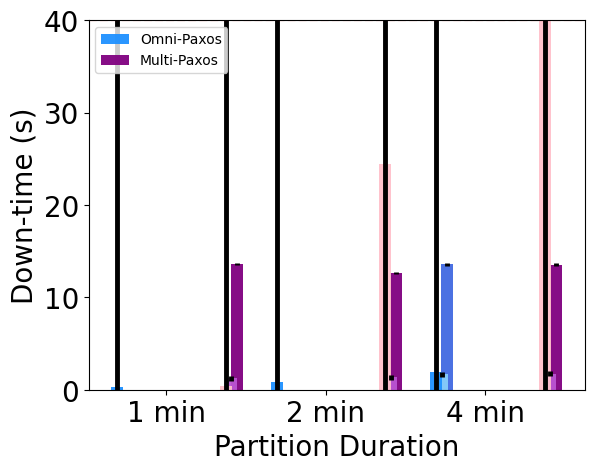

In [518]:
CONSTRAINED_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/constrained/meta_results/constrained-paxos-mple-part1/5-500-off/longest_down_time"
all_constrained = read_dir(CONSTRAINED_DIR, False, "constrained")
plot_all_bars(all_constrained)

## Quorum-loss Scenario

In [412]:
QUORUMLOSS_DIR = #TODO
all_quorumloss = read_dir(QUORUMLOSS_DIR, False, "quorum_loss")
plot_all_bars(all_quorumloss)

SyntaxError: invalid syntax (245067544.py, line 1)

## Chained Scenario

In [426]:
UNIT = 1000000

def plot_all_chained(all_groups):
    x_ticks = []
    x_labels = []
    for k in range(len(all_groups)):
        group_base = (k+1) * GROUP_DIST
        (partition_duration, group) = all_groups[k]
        for i in range(len(group)):
            (algo, (algo_group, ci)) = group[i]
            base = group_base % len(group) + (i+1)*BASE
            algo_group_len = len(algo_group)
            for j in range(algo_group_len):
                timeout = TIMEOUTS[j]
                label = "{} {}".format(algo, timeout)
                bar_dist = (j)*BAR_DIST
                y = algo_group[j]
                #bar_dist = (j)*BAR_DIST
                #y = algo_group[j]
                x = base + bar_dist
                #print("x: {}, y: {}".format(x, y))
                #plt.bar(x, y, align='edge', width=BAR_WIDTH, color=util.colors[label], alpha=0.95, yerr = ci[algo_group_len - j-1]/1000, ecolor = error_bar_color, error_kw = {"elinewidth": 3.5})
                (ci_lo, ci_hi) = ci[j]
                if y > 0:
                    plt.errorbar(x, y/UNIT, yerr = (ci_hi/UNIT-ci_lo/UNIT)/2, color=util.colors[label], elinewidth=3, zorder=1)
                    plt.scatter(x, y/UNIT, color=util.colors[label], s=130, zorder=2, marker=util.markers[partition_duration], edgecolors="black")
                if j == 1:
                    x_ticks.append(x)
                    x_labels.append(algo)
                    
    SIZE = 20
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels

    plt.xticks(x_ticks, x_labels)
    plt.tick_params(axis='both', which='major', labelsize=SIZE)
    plt.ylabel("Number of Decided (million ops)", size=20)

Reading raft,3,500,5min,off,none,chained-240,5000ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,50ms.data ...
Reading raft,3,500,5min,off,none,chained-240,50ms.data ...
Reading raft,3,500,5min,off,none,chained-240,500ms.data ...
Reading mple,3,500,5min,off,none,chained-240,50ms.data ...
Reading mple,3,500,5min,off,none,chained-240,5000ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,5000ms.data ...
Reading mple,3,500,5min,off,none,chained-240,500ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,500ms.data ...


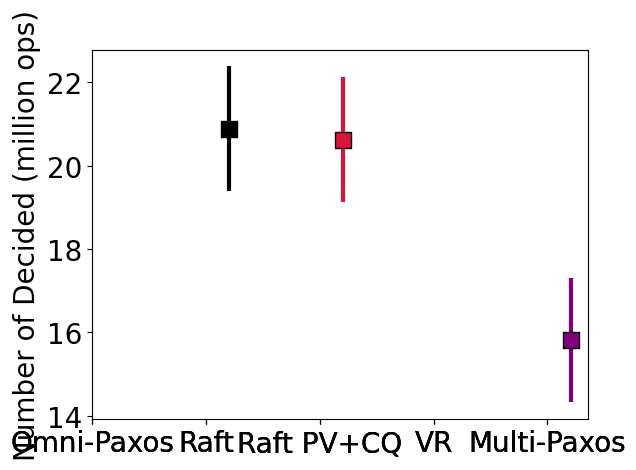

In [413]:
CHAINED_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/chained/meta_results/chained-mple-raft-part1/3-500-off/num_decided"
all_chained = read_dir(CHAINED_DIR, True, "chained")
plot_all_chained(all_chained)

# Normal

In [503]:
def get_empty_dict_normal():
    return {
        'Omni-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        'Raft, n=3' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        
        'Omni-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
        'Raft, n=5' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
    }

def get_cp_idx(cp):
    if cp == 500:
        return 0
    elif cp == 5000:
        return 1
    else:
        return 2
    
def get_dict_key_normal(algo, num_nodes):
    if algo == "paxos":
        algo = "Omni-Paxos"
    elif algo == "mp" or algo == "mple" or algo == "multi-paxos":
        algo = "Multi-Paxos"
    elif algo == "raft" or algo == "raft_pvqc":
        algo = "Raft"
    return "{}, n={}".format(algo, num_nodes)    

In [504]:
EXP_DURATION = 5 * 60

def to_tp(num_proposals):
    return num_proposals/EXP_DURATION

def ci_to_err_tp(ci):
    (lo, hi) = ci
    (lo_tp, hi_tp) = (to_tp(hi), to_tp(lo))
    err = (hi_tp-lo_tp)/2
    return err

In [505]:
def read_normal_dir(p):
    all_series = get_empty_dict_normal()
    directories = [f.path for f in os.scandir(p) if f.is_dir()]
    for d in directories:
        decided_path = "{}/num_decided".format(d)
        data_files = [f for f in os.listdir(decided_path) if f.endswith('.data') and 'fully_connected' in f]
        for filename in data_files:
            f = open(decided_path + "/" + filename, 'r')
            print("Reading", filename, "...")
            # paxos,5,500,5min,off,none,constrained_election-240,500ms
            dir_split = filename.split(',')
            algo = dir_split[0]            
            num_nodes = int(dir_split[1])
            num_cp = int(dir_split[2])
            all_y = []
            for line in f:
                num_decided = float(line.split('|')[0])
                y = to_tp(num_decided)
                all_y.append(y)
            mean = np.mean(all_y)
            ci_decided = student_t_ci(all_y)
            ci = ci_to_err_tp(ci_decided)
            cp_idx = get_cp_idx(num_cp)
            dict_key = get_dict_key_normal(algo, num_nodes)
            #print(dict_key)

            (all_mean, all_ci) = all_series[dict_key]
            all_mean[cp_idx] = mean
            all_ci[cp_idx] = ci
        
    return all_series

In [506]:
x_axis = [1, 2, 3]
num_cp = ["500", "5k", "50k"]

def plot_normal(all_series):
    for (label, (data, ci)) in all_series.items():
        if all(data > 0):
            #print(label)
            color = util.colors[label]
            split = label.split(",")
            linestyle = util.linestyles[split[0]]
            marker = util.markers[split[1]]
            plt.errorbar(x_axis, data, label=label, color=color, marker=marker, linestyle=linestyle, yerr=ci, capsize=8)
        
    ax = plt.gca()
    ax.yaxis.set_major_formatter(util.format_k)
    ax.legend(loc = "lower right", fontsize=19, ncol=1)
    #ax.legend()
    #fig.set_size_inches(15, 3.5)
    ax.set_ylabel('Throughput (ops/s)')
    ax.set_xlabel('Number of concurrent proposals')
    ax.set_ylim(bottom=0)
    plt.xticks(x_axis, num_cp)
    #plt.yticks(np.arange(0, 175000, 25000).tolist())
    #ax.set_ylim(bottom=0)


Reading paxos,3,500,5min,off,none,fully_connected,30000ms.data ...
Omni-Paxos, n=3
Reading raft,3,500,5min,off,none,fully_connected,30000ms.data ...
Raft, n=3
Reading raft,3,50000,5min,off,none,fully_connected,30000ms.data ...
Raft, n=3
Reading paxos,3,50000,5min,off,none,fully_connected,30000ms.data ...
Omni-Paxos, n=3
Reading raft,3,5000,5min,off,none,fully_connected,30000ms.data ...
Raft, n=3
Reading paxos,3,5000,5min,off,none,fully_connected,30000ms.data ...
Omni-Paxos, n=3
Omni-Paxos, n=3
Raft, n=3


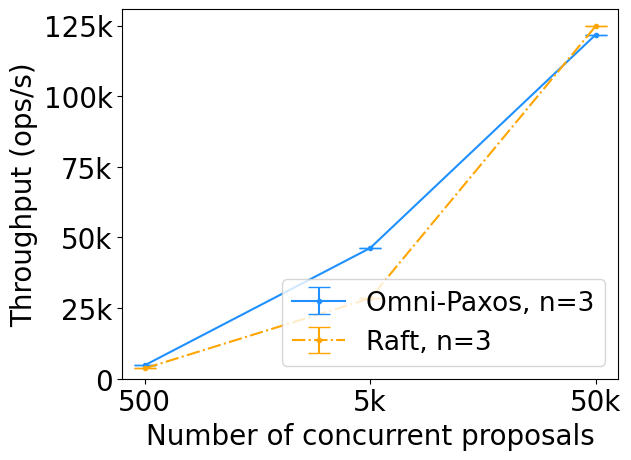

In [507]:
NORMAL_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/full-wan/paxosraft-fullwan-part1"
all_series = read_normal_dir(NORMAL_DIR)
plot_normal(all_series)


# Reconfiguration

In [508]:
WINDOW_DURATION = 5
PLOT_CI = True

In [532]:
def get_label_and_color(filename):
    csv = filename.split(",")
    algorithm = csv[0]
    if algorithm == "paxos":
        algorithm = "Omni-Paxos"
    else:
        algorithm = "Raft"
    reconfig = csv[5]
    if reconfig == "none":
        label = algorithm
    else:
        label = "{} {}".format(algorithm, reconfig.replace("-", " "))
    color = colors[label]
    return (label, color)

def get_linestyle_and_marker(label):
    split = label.split(" ", 1)
    algo = split[0]
    duration = split[1]
    linestyle = linestyles[algo]
    marker = markers[duration]
    return (linestyle, marker)

In [536]:
def plot_tp_windows(p):
    max_ts = 0
    #print(p)
    data_files = [f for f in os.listdir(p) if f.endswith('.data') and 'replace' in f]
    data_files.sort()
    for filename in data_files:
        f = open(p + "/" + filename, 'r')
        print("Reading", filename, "...")
        all_tp = []
        for line in f:
            
            #splitted = line.split('|')
            #assert len(splitted) == 2 # windows and number of warmup windows
            #num_decided_per_window = splitted[0].split(",")
            
            num_decided_per_window = line.split(",")
            #if filename != "raft,5,50000,20000000,majority,replace-follower.data":
                #del num_decided_per_window[-5:]
            if len(num_decided_per_window) < 2:
                continue
            for window_idx, num_decided in enumerate(num_decided_per_window):
                if num_decided.isdigit():
                    tp = int(num_decided) / WINDOW_DURATION
                    if len(all_tp) <= window_idx:
                        all_tp.append([])
                    all_tp[window_idx].append(tp)

        all_ts = []
        all_avg_tp = []
        all_ci95_lo = []
        all_ci95_hi = []

        all_min_tp = []
        all_max_tp = []

        all_tp_filtered = list(filter(lambda x: len(x) == 10, all_tp))
        #print(len(all_tp_filtered))
        for (window_idx, all_tp_per_window) in enumerate(all_tp_filtered):
            ts = (window_idx+1) * WINDOW_DURATION
            if ts > max_ts:
                max_ts = ts
            all_ts.append(ts)
            #all_ts.append(format_time(seconds=(i+1) * WINDOW_DURATION))
            avg_tp = sum(all_tp_per_window)/len(all_tp_per_window)
            all_avg_tp.append(avg_tp)

            min_tp = min(all_tp_per_window)
            max_tp = max(all_tp_per_window)
            all_min_tp.append(min_tp)
            all_max_tp.append(max_tp)
            
            if PLOT_CI:
                if (sum(all_tp_per_window) > 0 and len(all_tp_per_window) > 1):
                    (ci95_lo, ci95_hi) = student_t_ci(all_tp_per_window)
                    if ci95_lo < 0:
                        ci95_lo = 0
                    all_ci95_lo.append(ci95_lo)
                    all_ci95_hi.append(ci95_hi)
                else:
                    all_ci95_lo.append(all_tp_per_window[0])
                    all_ci95_hi.append(all_tp_per_window[0])
                    
        (label, color) = get_label_and_color(filename)
        print(label)
        (linestyle, marker) = get_linestyle_and_marker(label)
        plt.plot(all_ts, np.array(all_avg_tp), color=color, label=label, linestyle=linestyle, marker=marker),
        if PLOT_CI:
            plt.fill_between(all_ts, all_ci95_lo, all_ci95_hi, color=color, alpha=0.2)
   
    ax = plt.gca()
    MEDIUM_SIZE = 18
    #ax.legend(loc = "upper center", fontsize=13.3, ncol=2)
    x_axis = np.arange(0, max_ts+4*WINDOW_DURATION, 4*WINDOW_DURATION)
    y_axis = np.arange(0, 170000, 25000)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(MEDIUM_SIZE)

    plt.xlabel("Time")
    plt.xticks(x_axis)
    plt.yticks(y_axis)
    #plt.ylim(top=165000)

    #plt.ticklabel_format(axis=x, style=format_time)
    #plt.ticklabel_format(y, format_k)
    ax.xaxis.set_major_formatter(format_time)
    ax.yaxis.set_major_formatter(format_k)

    plt.ylim(bottom=0)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Throughput (ops/s)")
    
    split = p.split("/")
    exp_str = split[len(split)-3]
    exp_str_split = exp_str.split("-")
    num_cp = 500
    num_cp_int = int(num_cp)
    if num_cp_int > 1000:
        num_cp = "{}k".format(int(num_cp_int/1000)) 
    reconfig = exp_str_split[len(exp_str_split) - 1]
    title = "{} concurrent proposals".format(num_cp)
    #title = "Periodic full partition scenario"
    if reconfig != "off":
        title += ", {} reconfiguration".format(reconfig)

Reading paxos,5,500,5min,single,replace-follower,fully_connected,10000ms.data ...
Omni-Paxos replace follower
Reading paxos,5,500,5min,single,replace-leader,fully_connected,10000ms.data ...
Omni-Paxos replace leader
Reading raft,5,500,5min,single,replace-follower,fully_connected,10000ms.data ...
Raft replace follower
Reading raft,5,500,5min,single,replace-leader,fully_connected,10000ms.data ...
Raft replace leader


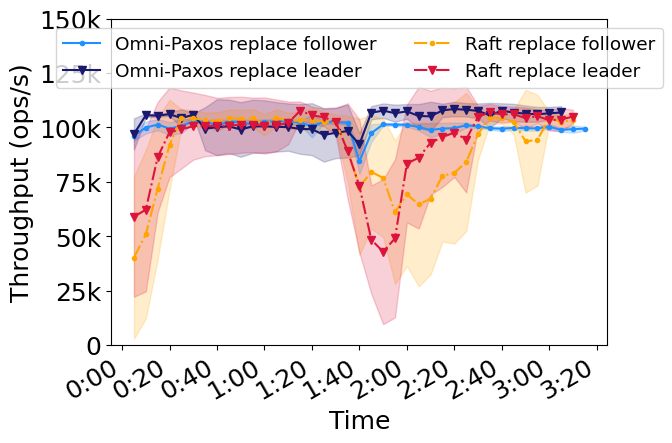

In [534]:
#RECONFIG_SINGLE_CP500 = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/2021-07-28-reconfig/5-500-single/windowed"
RECONFIG_SINGLE_CP500 = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/twenty1/meta_results/twenty1/5-500-single/windowed"
plot_tp_windows(RECONFIG_SINGLE_CP500)


Reading paxos,5,50000,5min,single,replace-follower,fully_connected,10000ms.data ...
Omni-Paxos replace follower
Reading paxos,5,50000,5min,single,replace-leader,fully_connected,10000ms.data ...
Omni-Paxos replace leader
Reading raft,5,50000,5min,single,replace-follower,fully_connected,10000ms.data ...
Raft replace follower
Reading raft,5,50000,5min,single,replace-leader,fully_connected,10000ms.data ...
Raft replace leader


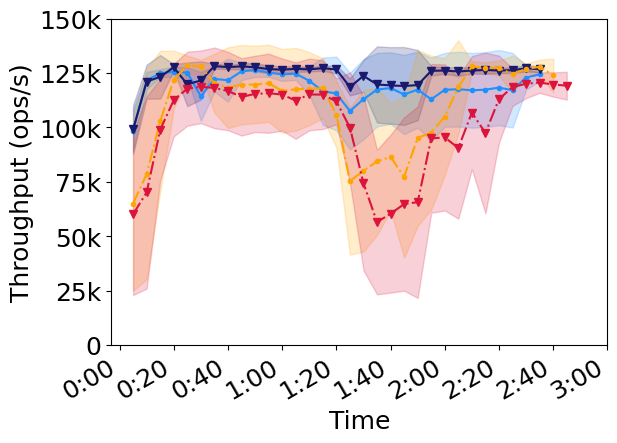

In [537]:
RECONFIG_SINGLE_CP50K = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/twenty1/meta_results/twenty1/5-50000-single/windowed"

plot_tp_windows(RECONFIG_SINGLE_CP50K)

Reading paxos,5,50000,5min,majority,replace-follower,fully_connected,10000ms.data ...
Omni-Paxos replace follower
Reading paxos,5,50000,5min,majority,replace-leader,fully_connected,10000ms.data ...
Omni-Paxos replace leader
Reading raft,5,50000,5min,majority,replace-follower,fully_connected,10000ms.data ...
Raft replace follower
Reading raft,5,50000,5min,majority,replace-leader,fully_connected,10000ms.data ...
Raft replace leader


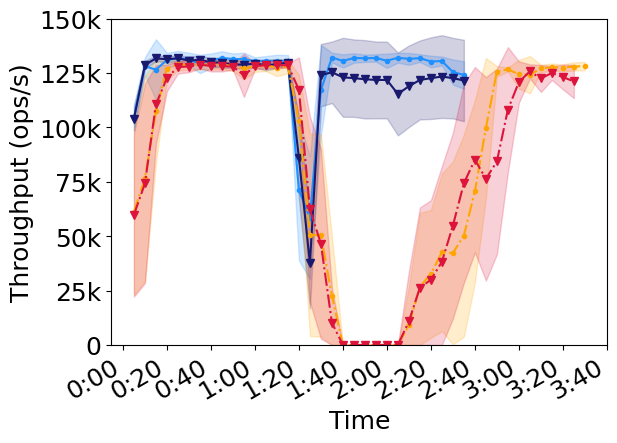

In [538]:
RECONFIG_MAJORITY_CP50K = RECONFIG_SINGLE_CP500 = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/twenty1/meta_results/twenty1/5-50000-majority/windowed"
plot_tp_windows(RECONFIG_MAJORITY_CP50K)